## Task : To Compare L2 regularization and Dropout mechanism and see results

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.io
import sklearn
import sklearn.datasets
from nn_util import *
%matplotlib inline

In [4]:
def load_football_dataset():

    data = scipy.io.loadmat('datasets/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T
    
    return train_X,train_Y,test_X,test_Y

In [7]:
train_X,train_Y,test_X,test_Y = load_football_dataset()

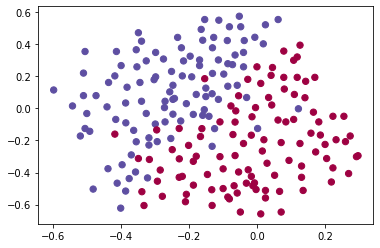

In [9]:
plt.scatter(train_X[0,:],train_X[1,:],c = train_Y, s= 40, cmap = plt.cm.Spectral)



Each dot corresponds to a position on the football field where a football player has hit the ball with his/her head after the French goal keeper has shot the ball from the left side of the football field.

    If the dot is blue, it means the French player managed to hit the ball with his/her head
    If the dot is red, it means the other team's player hit the ball with their head

*Our goal*: Use a deep learning model to find the positions on the field where the goalkeeper should kick the ball.

Analysis of the dataset: This dataset is a little noisy, but it looks like a diagonal line separating the upper left half (blue) from the lower right half (red) would work well.

We will first try a non-regularized model. Then we'll learn how to regularize it and decide which model you will choose to solve the French Football Corporation's problem.


In [26]:
def initialize_params(layers_dims) : 
    
    params = {}
    L = len(layers_dims)
    for l in range(1,L) : 
        params['w' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1])*(1/np.sqrt(layers_dims[l-1]))
        params['b' + str(l)] = np.zeros((layers_dims[l],1))
    return params

## L2 regularization 

In [42]:
# cost computation with L2 regularization added
def compute_cost_with_regularization(a3,Y,params,lambd) : 
    m = Y.shape[1]
    w1 = params['w1']
    w2 = params['w2']
    w3 = params['w3']
    
    cross_entropy_cost = compute_cost(a3,Y)
    
    L2_regularization_cost = lambd/(2*m) * (np.sum(np.square(w1)) + np.sum(np.square(w2)) + np.sum(np.square(w3)))
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [48]:
# Backward prop with L2 regularization added
def backward_prop_with_regularization(X,Y,cache,lambd) : 
    
    m = X.shape[1]
    (z1,a1,w1,b1,z2,a2,w2,b2,z3,a3,w3,b3) = cache
    
    dz3 = a3 - Y
    
    dw3 = 1/m*np.dot(dz3,a2.T) + (lambd/m)*w3
    
    db3 = 1/m * np.sum(dz3,axis = 1,keepdims = True)
    
    da2 = np.dot(w3.T,dz3)
    
    dz2 = np.multiply(da2, np.int64(a2 > 0))

    dw2 = 1./m * np.dot(dz2, a1.T) + (lambd/m)*w2

    db2 = 1./m * np.sum(dz2, axis=1, keepdims = True)
    
    da1 = np.dot(w2.T, dz2)
    
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    
    dw1 = 1./m * np.dot(dz1, X.T) + (lambd/m)*w1
    
    db1 = 1./m * np.sum(dz1, axis=1, keepdims = True)
    
    gradients = {"dz3": dz3, "dw3": dw3, "db3": db3,"da2": da2,
                 "dz2": dz2, "dw2": dw2, "db2": db2, "da1": da1, 
                 "dz1": dz1, "dw1": dw1, "db1": db1}
    
    return gradients
    

## Dropout

In [69]:
# forward propogation with dropout
def forward_prop_with_dropout(X,params,keep_prob = 0.5) : 
    
    w1 = params['w1']
    w2 = params['w2']
    w3 = params['w3']
    b1 = params['b1']
    b2 = params['b2']
    b3 = params['b3']
    
    z1 = np.dot(w1,X) + b1
    a1 = relu(z1)
    
    # Dropout vector for layer 1 (acts like a bool mask for activation layer)
    D1 = np.random.rand(a1.shape[0],a1.shape[1])
    D1 = (D1 < keep_prob) # converting entries to 0 or 1 with keep_prob probability having 1s and (1-keep_prob) as 0
    a1 = a1 * D1 # shutting down some neurons 
    a1 = a1/keep_prob # scaling the values of neurons that haven't been shut down
    
    z2 = np.dot(w2,a1) + b2
    a2 = relu(z2)
    
    D2 = np.random.rand(a2.shape[0],a2.shape[1])
    D2 = (D2 < keep_prob) 
    a2 = a2 * D2
    a2 = a2/keep_prob
    
    z3 = np.dot(w3,a2) + b3
    a3 = sigmoid(z3)
    
    cache = (z1,D1,a1,w1,b1,z2,D2,a2,w2,b2,z3,a3,w3,b3)
    
    return a3,cache

In [76]:
# Backward Propogation with Dropout
def backward_prop_with_dropout(X,Y,cache,keep_prob) :
    
    m = X.shape[1]
    (z1,D1,a1,w1,b1,z2,D2,a2,w2,b2,z3,a3,w3,b3) = cache
    
    dz3 = a3 - Y
    dw3 = 1/m * (np.dot(dz3,a2.T))
    db3 = 1/m * np.sum(dz3,axis = 1,keepdims=True)
    da2 = np.dot(w3.T,dz3) 
    
    # applying D2 mask to shut down the same neurons as were in forward prop
    da2 = da2 * D2
    # scaling the value of neurons that haven't been shutdown to match the expected value
    da2 = da2/keep_prob 
    
    dz2 = np.multiply(da2,np.int64(a2 > 0))
    dw2 = 1/m * np.dot(dz2,a1.T)
    db2 = 1/m * np.sum(dz2,axis = 1,keepdims=True)
    
    da1 = np.dot(w2.T,dz2)
    # applying D1 mask to shut down the same as were in forward prop 
    da1 = da1 * D1
    # scaling the value of neurons that haven't been shutdown to match the expected value
    da2 = da2/keep_prob
    
    dz1 = np.multiply(da1,np.int64(a1 > 0))
    dw1 = 1/m * np.dot(dz1,X.T)
    db1 = 1/m * np.sum(dz1,axis = 1,keepdims = True)
    
    gradients = {"dz3": dz3, "dw3": dw3, "db3": db3,"da2": da2,
                 "dz2": dz2, "dw2": dw2, "db2": db2, "da1": da1, 
                 "dz1": dz1, "dw1": dw1, "db1": db1}
    
    return gradients

In [77]:
def model(X,Y,learning_rate = 0.3,num_iterations = 30000,print_cost = True,lambd = 0,keep_prob = 1) : 
    
    grads = {}
    costs = []
    
    m = X.shape[1]
    layers_dims = [X.shape[0],20,3,1]
    
    # Initializing parameters
    params = initialize_params(layers_dims)
    
    for i in range(0,num_iterations) : 
        
        # Forward prop : 
        # Linear->Relu -> Linear->Relu -> Linear->Sigmoid
        
        if keep_prob == 1 : 
            a3,cache = forward_prop(X,params)
            
        if keep_prob < 1 :
            # Dropout mechanism
            a3,cache = forward_prop_with_dropout(X,params,keep_prob)        
        
        
        # Compute cost
        if lambd == 0 : 
            cost = compute_cost(a3,Y)
        else :
            # L2 regularization
            cost = compute_cost_with_regularization(a3,Y,params,lambd)
        
        # Backward prop
        if lambd == 0 and keep_prob == 1 : 
            grads = backward_prop(X,Y,cache)
        elif lambd != 0 : 
            grads = backward_prop_with_regularization(X,Y,cache,lambd)
        elif keep_prob < 1 : 
            grads = backward_prop_with_dropout(X,Y,cache,keep_prob)
        
        # Update params
        
        params = update_parameters(params,grads,learning_rate)
        
        if print_cost and i % 3000 == 0:
            print("Cost after iteration {} : {}".format(i,cost))
            costs.append(cost)
    # plot loss
    plt.plot(costs)
    plt.xlabel('cost')
    plt.ylabel('iteration per 3000')
    plt.title('Learning rate = ' + str(learning_rate))
    plt.show()
    
    return params
        

## Non-regularized model

Cost after iteration 0 : 0.6747887596749796
Cost after iteration 3000 : 0.19677830552604478
Cost after iteration 6000 : 0.17934752684888727
Cost after iteration 9000 : 0.14122684679925102
Cost after iteration 12000 : 0.132741071318956
Cost after iteration 15000 : 0.11791201132021686
Cost after iteration 18000 : 0.09793870485667629


/home/ape/Deep learning stuff/deeplearning.ai implementation/improving neural networks/nn_util.py:78: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
/home/ape/Deep learning stuff/deeplearning.ai implementation/improving neural networks/nn_util.py:78: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)


Cost after iteration 21000 : 0.10359932730797017
Cost after iteration 24000 : 0.09797178639433642
Cost after iteration 27000 : 0.09455894082697734


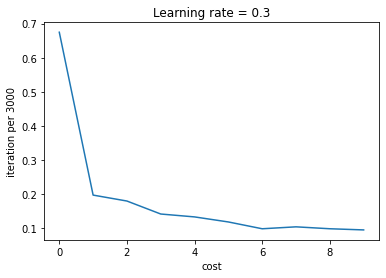

In [62]:
parameters = model(train_X, train_Y)

In [63]:
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

On the training set:
Accuracy: 0.9620853080568721
On the test set:
Accuracy: 0.915


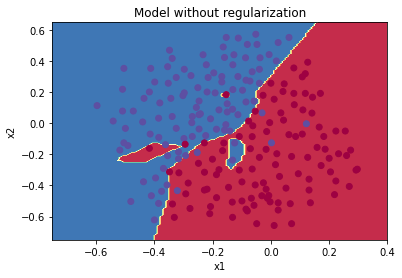

In [64]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## L2 regularized model

Cost after iteration 0 : 0.6987634947003727
Cost after iteration 3000 : 0.2682094049259
Cost after iteration 6000 : 0.2670721463359036
Cost after iteration 9000 : 0.26629810446606744
Cost after iteration 12000 : 0.26710802057934085
Cost after iteration 15000 : 0.2659477179471829
Cost after iteration 18000 : 0.26611207717083823
Cost after iteration 21000 : 0.2664102141787293
Cost after iteration 24000 : 0.2652823226170679
Cost after iteration 27000 : 0.2651603164413651


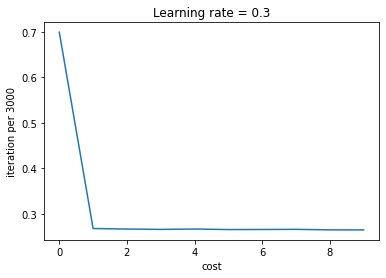

In [65]:
parameters = model(train_X,train_Y,lambd = 0.7)

In [66]:
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

On the train set:
Accuracy: 0.933649289099526
On the test set:
Accuracy: 0.925


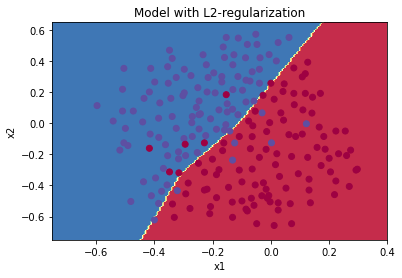

In [67]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost after iteration 0 : 0.6844655481453342
Cost after iteration 3000 : 0.2043838612690841
Cost after iteration 6000 : 0.23166498359419224
Cost after iteration 9000 : 0.2063610441965944
Cost after iteration 12000 : 0.20345978072268936
Cost after iteration 15000 : 0.22158329303507865
Cost after iteration 18000 : 0.21922572492912898
Cost after iteration 21000 : 0.19185220902265815
Cost after iteration 24000 : 0.17655850003260756
Cost after iteration 27000 : 0.17561387128428435


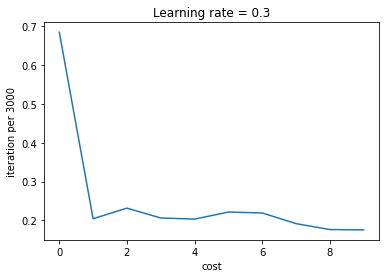

In [78]:
parameters = model(train_X,train_Y,keep_prob=0.86,learning_rate = 0.3)

In [79]:
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

On the train set:
Accuracy: 0.957345971563981
On the test set:
Accuracy: 0.93


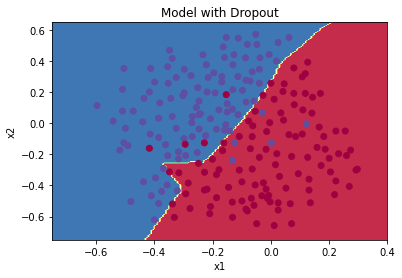

In [81]:
plt.title("Model with Dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

 * A common mistake when using dropout is to use it both in training and testing. You should use dropout (randomly eliminate nodes) only in training.
* Dropout is a regularization technique.
* You only use dropout during training. Don't use dropout (randomly eliminate nodes) during test time.
* Apply dropout both during forward and backward propagation. 

* During training time, divide each dropout layer by keep_prob to keep the same expected value for the activations. For example, if keep_prob is 0.5, then we will on average shut down half the nodes, so the output will be scaled by 0.5 since only the remaining half are contributing to the solution. Dividing by 0.5 is equivalent to multiplying by 2. Hence, the output now has the same expected value. You can check that this works even when keep_prob is other values than 0.5. 

## Conclusion :

| **Model**                                   | **Train accuracy** | **Test accuracy**|
|---------------------------------------------|--------------------|------------------|
| 3-layer NN without regularization           | 96.2%              | 91.5%            |
| 3-layer NN with L2 regularization           | 93.4%              | 92.5%            |
| 3-layer NN with dropout                     | 95.7%              | 93%              |

#### Dropout resulted in overall good performance, model is not overfitting on training set and did great job on test set